In [14]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random

from torch.distributions.categorical import Categorical
from typing import List
from tqdm import tqdm

import sys
sys.path.insert(1, '../src')
from config import *
from alphaclass import AlphaGFN
from models import TBModel
from reward import compute_log_reward
from loss import trajectory_balance_loss

In [15]:
# Utils
def expr_sequence_to_string(expr: List[str]) -> str:
    string = ''
    stack = []
    for a in expr:
        if a in ['BEG', 'SEP']:
            continue
        elif a in FEATURES:
            stack.append(a)
        elif a in UNARY:
            operand = stack.pop()
            stack.append(a + '(' + operand + ')')
        elif a in BINARY:
            operand_2 = stack.pop()
            operand_1 = stack.pop()
            stack.append(a + '(' + operand_1 + ',' + operand_2 + ')')
        else:
            ValueError
    return stack[0]

# Training Loop

In [17]:
# Reproducibility.
seed = 2024
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Instantiate model and optimizer
model = TBModel(num_hid_1 = 128, num_hid_2 = 128)
opt = torch.optim.Adam(model.parameters(),  learning_rate)

# Accumulate losses here and take a gradient step every `update_freq` episode (at the end of each trajectory).
losses, sampled_ics, sampled_expressions, logZs = [], [], [], []
minibatch_loss = torch.tensor([0], dtype=torch.float32)
update_freq = 20

n_episodes = 100

alpha = AlphaGFN()

for episode in tqdm(range(n_episodes), ncols=100):
    
    alpha.reset()  # Each episode starts with an empty state and operand stack.
    P_F_s, P_B_s = model(alpha.get_tensor_state().unsqueeze(0))  # Forward and backward policy
    total_log_P_F, total_log_P_B = 0, 0

    for t in range(MAX_EXPR_LENGTH):  # All trajectories are at most length MAX_EXPR_LENGTH.

        # Here we mask the relevant forward actions.
        mask = alpha.get_forward_masks()
        P_F_s = torch.where(mask, P_F_s, torch.tensor(-100, dtype=torch.float32))  # Removes invalid forward actions.

        # Here P_F is logits, so we use Categorical to compute a softmax.
        categorical = Categorical(logits=P_F_s)
        action = categorical.sample()  # Sample the next action.
        alpha.step(action)  # Update to new state.
        total_log_P_F += categorical.log_prob(action)  # Accumulate the log_P_F sum.

        # We recompute P_F and P_B for the new state.
        P_F_s, P_B_s = model(alpha.get_tensor_state().unsqueeze(0))
        mask = alpha.get_backward_masks()
        P_B_s = torch.where(mask, P_B_s, torch.tensor(-100, dtype=torch.float32))  # Removes invalid backward actions.

        # Accumulate P_B, going backwards from new state. 
        total_log_P_B += Categorical(logits=P_B_s).log_prob(action)
        
        if alpha._action_to_token(action) == "SEP":  # End of trajectory.
            break

    if alpha._action_to_token(action) == "SEP":
        ic, log_reward = compute_log_reward(alpha.stack[0])
        if not np.isnan(log_reward):
            minibatch_loss += trajectory_balance_loss(
                model.logZ,
                total_log_P_F,
                total_log_P_B,
                log_reward = torch.tensor(log_reward, dtype=torch.float32),
            )

            sampled_expressions.append([alpha._action_to_token(action) for action in alpha.state])
            sampled_ics.append(ic) 
        
    if episode > 0 and episode % update_freq == 0 and minibatch_loss:
        losses.append(minibatch_loss.item())
        logZs.append(model.logZ.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0


100%|█████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.15s/it]


# Examine training results

## Loss curve and estimated partition function over time

Text(0.5, 0.98, 'Loss and Estimated Partition Function for the Trajectory Balance Model')

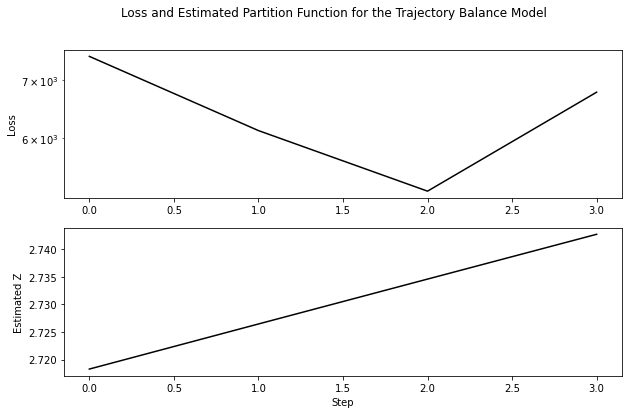

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plt.sca(ax[0])
plt.plot(losses, color="black")
plt.yscale('log')
plt.ylabel('Loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs), color="black")
plt.ylabel('Estimated Z');
plt.xlabel('Step')
plt.suptitle("Loss and Estimated Partition Function for the Trajectory Balance Model")

## Example expressions and their IC

In [19]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.html.use_mathjax', False)
res = pd.DataFrame(
    {'expr': [expr_sequence_to_string(ex) for ex in sampled_expressions], 'ic': sampled_ics}
).sort_values(by='ic')
res

,expr,ic
45,"ops_subtract(ops_divide(ops_add(ops_subtract(ops_abs(ops_multiply($open,ops_roll_std($close))),$volume),ops_roll_std($high)),ops_roll_std($close)),$open)",-0.015941
20,"ops_add(ops_subtract(ops_roll_corr(ops_add(ops_roll_std(ops_abs(ops_add(ops_roll_std(ops_add($close,ops_abs($high))),$open))),ops_abs($high)),ops_roll_std($low)),$volume),$close)",-0.015171
39,"ops_subtract(ops_add($open,$low),$volume)",-0.015163
46,"ops_subtract(ops_subtract($high,$volume),ops_log(ops_abs($close)))",-0.015160
31,"ops_subtract($low,$volume)",-0.015160
...,...,...
53,"ops_add($volume,$close)",0.015160
71,$volume,0.015162
16,ops_abs($volume),0.015162
27,"ops_subtract(ops_add($open,$volume),ops_roll_std($high))",0.015249


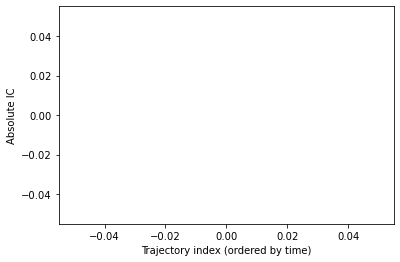

In [20]:
# Reset index to create a new column with original index values
res['original_index'] = res.index
res0 = res.sort_values(by='original_index')
ic_ma = res0['ic'].rolling(window=100).mean()
plt.plot(range(len(ic_ma)), np.abs(ic_ma), label='Line')
plt.xlabel('Trajectory index (ordered by time)')
plt.ylabel('Absolute IC')
plt.show()

array([[<AxesSubplot:title={'center':'ic'}>]], dtype=object)

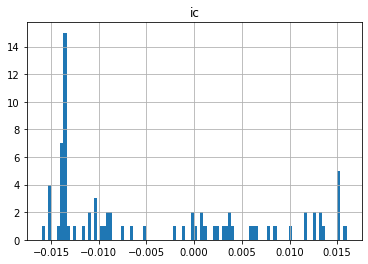

In [21]:
res.hist('ic', bins=100)

## Zooming-in: groups of expressions with high absolute ICs 

From the following frequency plots, we may observe that: 
 - In all groups, `$volume` is a dominating action that drives high absolute IC.
 - `ops_multiply` occurs frequently in groups with |IC| > 0.05, compared to 0.04 < |IC| <= 0.05.
 - `ops_roll_std` occurs frequently in all groups.
 - `ops_log` and `ops_divide` occurs rarely, probably because it renders missingness with large chance.
 - `ops_subtract` ranks high in frequency for group with positive ICs, which makes sense because it flips the sign of `$volume`.
 - None of the groups used `ops_roll_corr`.

In [22]:
## Negative IC
# IC < -0.05
expr_g1 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic < -0.05]
act_g1  = [a for expr in expr_g1 for a in expr]
# -0.05 <= IC< -0.04
expr_g2 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic >= -0.05 and ic < -0.04 for a in sampled_expressions[i]]
act_g2  = [a for expr in expr_g2 for a in expr]

## Positive IC
# IC >= 0.05
expr_g3 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic >= 0.05 for a in sampled_expressions[i]]
act_g3  = [a for expr in expr_g3 for a in expr]
# 0.04 <= IC< 0.05
expr_g4 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if ic >= 0.04 and ic < 0.05 for a in sampled_expressions[i]]
act_g4  = [a for expr in expr_g4 for a in expr]

In [23]:
from collections import Counter
count_g1 = Counter(act_g1).most_common()
count_g2 = Counter(act_g2).most_common()
count_g3 = Counter(act_g3).most_common()
count_g4 = Counter(act_g4).most_common()

In [24]:
labels, counts = zip(*count_g1)
plt.bar(labels, counts); plt.xticks(rotation=90)
plt.title('Frequency of actions in expresson with IC < -0.05')
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [25]:
labels, counts = zip(*count_g2)
plt.title('Frequency of actions in expresson with -0.05 <= IC< -0.04')
plt.bar(labels, counts); plt.xticks(rotation=90); plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [26]:
labels, counts = zip(*count_g3)
plt.title('Frequency of actions in expresson with IC >= 0.05')
plt.bar(labels, counts); plt.xticks(rotation=90); plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [27]:
labels, counts = zip(*count_g4)
plt.title('Frequency of actions in expresson with 0.04 <= IC< 0.05')
plt.bar(labels, counts); plt.xticks(rotation=90); plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

## Zooming-in: Groups of expressions with low absolute ICs 

From the frequency plots, we may observe that: 
 - No distinctive dominating actions.
 - The rank seems to be at random based on multiple times of running the optimization.

In [ ]:
# |IC| < 0.01
expr_g5 = [sampled_expressions[i] for i, ic in enumerate(sampled_ics) if np.abs(ic) < 0.01]
act_g5  = [a for expr in expr_g5 for a in expr]

In [ ]:
count_g5 = Counter(act_g5).most_common()
labels, counts = zip(*count_g5)
plt.bar(labels, counts); plt.xticks(rotation=90)
plt.title('Frequency of actions in expresson with |IC| < 0.01')
plt.show()